# Enhancing Video Analysis with AI-Powered Object Detection

In this day and age, AI-powered object detection is taking force—the ultimate game-changer. AI doesn't just lighten the load; it redefines the process. It transforms raw, unstructured video into actionable insights by identifying objects, tracking movements, detecting patterns, and predicting outcomes. 


This notebook will focus on **object detection for video datasets** using [**FiftyOne**](https://docs.voxel51.com/getting_started/install.html) and [**Virtual KITTI**](https://europe.naverlabs.com/research/computer-vision/proxy-virtual-worlds-vkitti-2/). 
This serves as both an exploration of these tools and a hands-on guide with practical code snippets. Here’s what you’ll learn:

1. **How to integrate and analyze video datasets** with FiftyOne and Virtual KITTI.
2. **How to leverage FiftyOne’s tools** to visualize and deeply understand your data.
3. **How to evaluate and refine object detection models** for video-based tasks.

Whether you’re looking to fine-tune your models or uncover insights buried in video streams, this walkthrough will provide the steps to harness AI’s full potential—one frame at a time.

In [2]:
import warnings
warnings.filterwarnings('ignore')
import torch
import fiftyone as fo
from fiftyone import ViewField as F
import matplotlib.pyplot as plt

## Setup

### Step 1: Create a Virtual Environment

Before installing any libraries, it's a good practice to isolate your project dependencies by creating a virtual environment 

 `python3 -m venv kitti-env`

### Step 2: Install Necessary Libraries

1. **Install FiftyOne** 

    `pip install fiftyone`

2. **Install PyTorch**

    `pip install torch torchvision torchaudio`

### Step 3: Verify Installations


In [2]:
# Verify FiftyOne
print(f"FiftyOne version: {fo.__version__}")

# Verify PyTorch
print(f"PyTorch version: {torch.__version__}")

FiftyOne version: 1.1.0
PyTorch version: 2.5.0+cu124


## Loading the Virtual KITTI Dataset

The Virtual KITTI dataset is a synthetic extension of the well-known KITTI dataset, specifically designed for video object detection tasks. It provides a controlled environment with diverse scenes, making it an excellent resource for testing and improving object detection models.

### **Step 1: Download the Dataset**
Download the [Virtual KITTI Dataset](https://europe.naverlabs.com/research/computer-vision/proxy-virtual-worlds-vkitti-2/), which includes RGB frames and label files in text format.

### **Step 2: Convert Frames to Videos**
To work with videos instead of individual frames, I used FFmpeg on a Linux machine to convert the frames into 5-second videos at 10 FPS. This process created separate videos for various scenes, including morning, fog, sunset, overcast, and rain.

I automated the conversion process with a simple bash script, saving all videos into a common folder—ready for seamless integration with FiftyOne for analysis and visualization.


In [3]:
kitti_data = fo.Dataset.from_videos_dir(videos_dir="./KITTI_videos",
                                        name="virtual-kitti-videos")

# if you wish to load the dataset from given name
# kitti_data = fo.load_dataset("virtual-kitti-videos")

 100% |█████████████████| 140/140 [89.6ms elapsed, 0s remaining, 1.6K samples/s]   


In [4]:
kitti_data.compute_metadata()
kitti_data

Computing metadata...
 100% |█████████████████| 140/140 [5.6s elapsed, 0s remaining, 31.3 samples/s]      


Name:        virtual-kitti-videos
Media type:  video
Num samples: 140
Persistent:  False
Tags:        []
Sample fields:
    id:               fiftyone.core.fields.ObjectIdField
    filepath:         fiftyone.core.fields.StringField
    tags:             fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:         fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.VideoMetadata)
    created_at:       fiftyone.core.fields.DateTimeField
    last_modified_at: fiftyone.core.fields.DateTimeField
Frame fields:
    id:               fiftyone.core.fields.ObjectIdField
    frame_number:     fiftyone.core.fields.FrameNumberField
    created_at:       fiftyone.core.fields.DateTimeField
    last_modified_at: fiftyone.core.fields.DateTimeField

Connected to FiftyOne on port 5151 at localhost.
If you are not connecting to a remote session, you may need to start a new session and specify a port



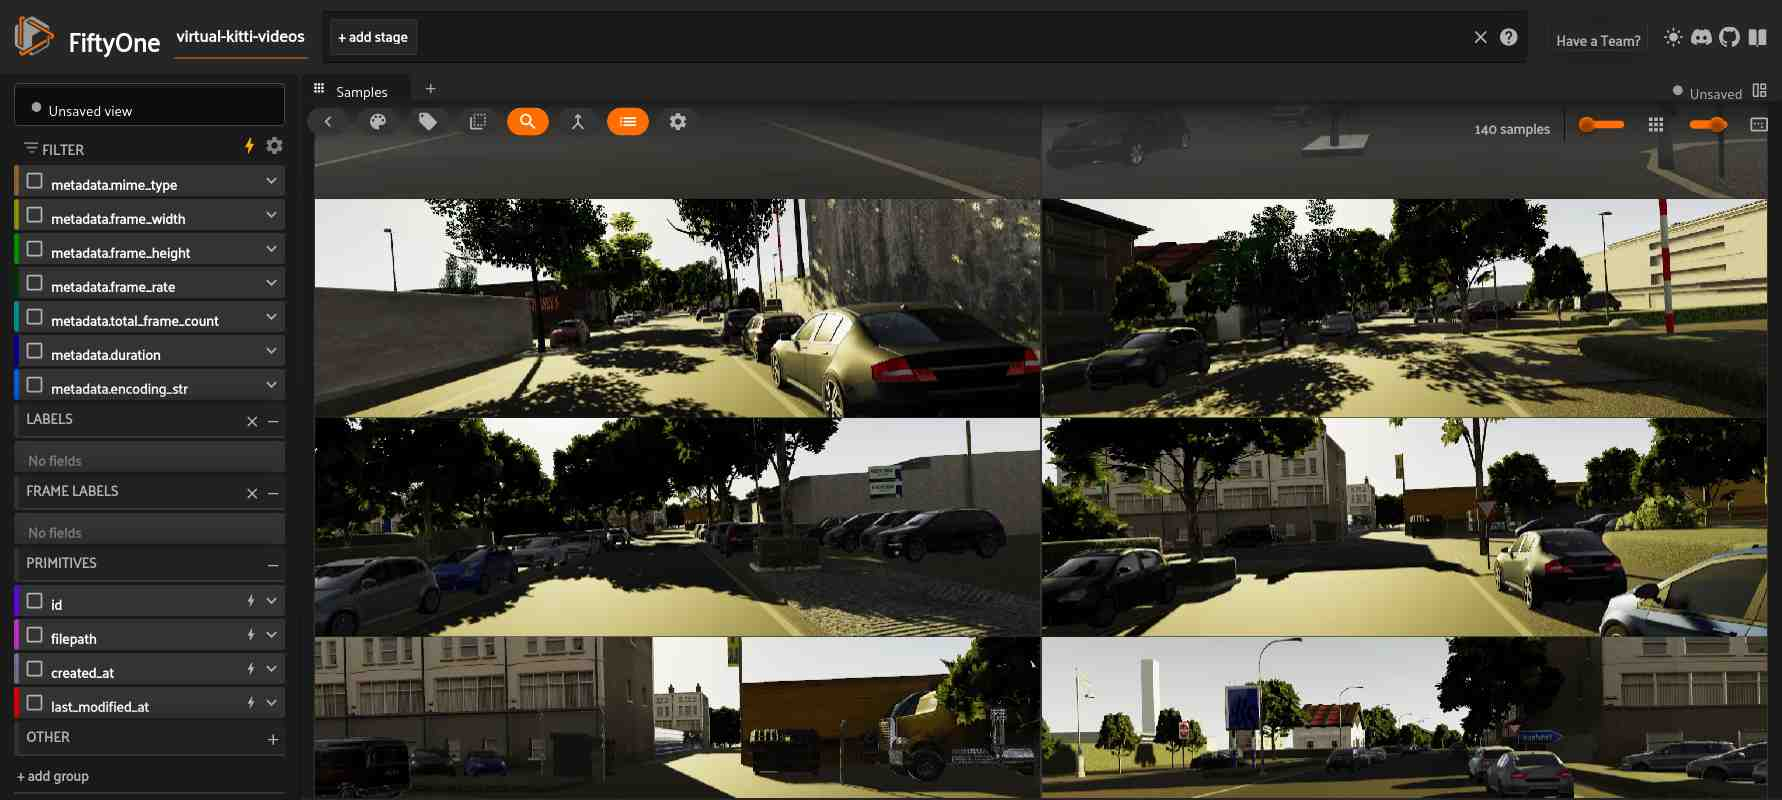

In [5]:
# Launch the FiftyOne app to visualize
session = fo.launch_app(kitti_data)

In [6]:
session.freeze()

## **Converting Videos to Frames**

To efficiently work with image-based tools in **FiftyOne**, it’s crucial to convert videos into individual frames. This step enables frame-level analysis and makes it easier to apply image-processing techniques.

To ensure that the frames are properly saved on the disk and accessible every time the dataset is loaded, it's essential to set `sample_frames = True`. This flag ensures that the file paths for the frames are stored, making it easier to reference each individual frame during analysis.


 100% |███████████████| 6800/6800 [225.1ms elapsed, 0s remaining, 30.6K samples/s]  
 100% |███████████████| 6800/6800 [108.4ms elapsed, 0s remaining, 64.1K samples/s]  
Setting 6800 frame filepaths on the input collection that exist on disk but are not recorded on the dataset



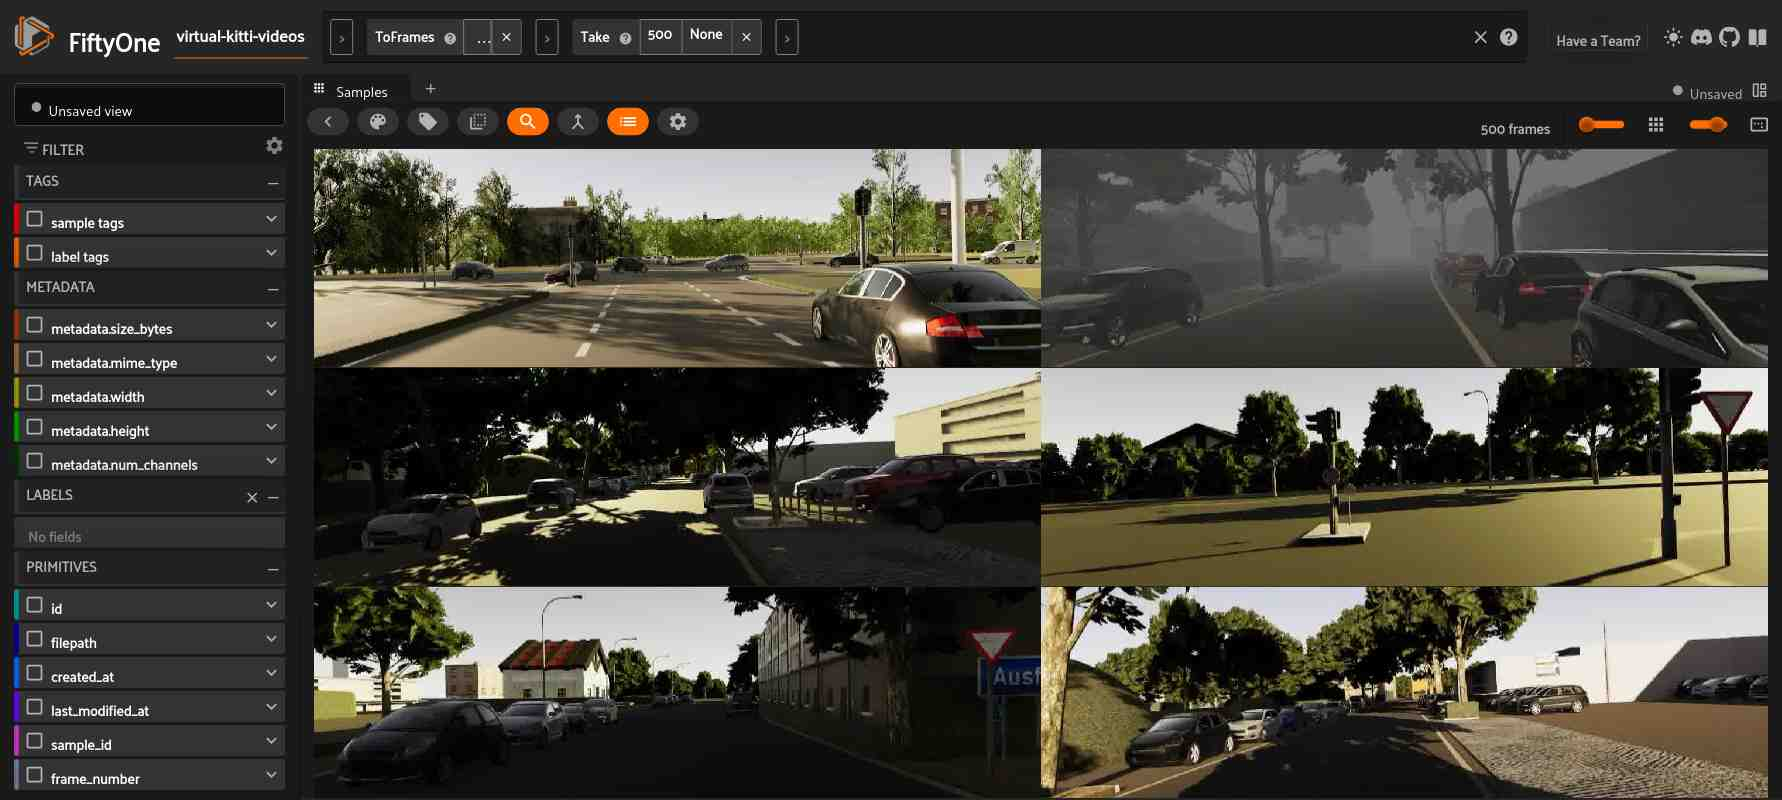

In [ ]:
frames = kitti_data.to_frames(sample_frames=True)
view_frames = frames.take(500)
session = fo.launch_app(view_frames)

In [8]:
session.freeze()

## **Compute Brightness**

In **FiftyOne**, you can compute the brightness of your dataset to help identify low-lit or high-lit frames, which can be crucial for model evaluation, especially in challenging lighting conditions.

### **Step 1: Access the Brightness Operation**
To compute brightness, follow these steps:

1. In the **Browse** view, navigate to the operations section (located before the settings icon).
2. Type **brightness** in the search bar. This will bring up the option to compute brightness for the entire dataset or just the current view.

### **Step 2: Execute the Operation**
Once you've selected the appropriate option, click **Execute**. This will process the brightness of the frames in your dataset.

### **Step 3: Visualize the Brightness**
After the computation is done, you will see a new **"Brightness"** row added to the left sidebar. This row allows you to:

- Adjust the **brightness range**.
- Filter and visualize **low-lit** or **high-lit** frames.

You can use this feature to focus on specific frames where lighting may impact object detection performance, enabling you to address challenges related to poor lighting in your model evaluation.



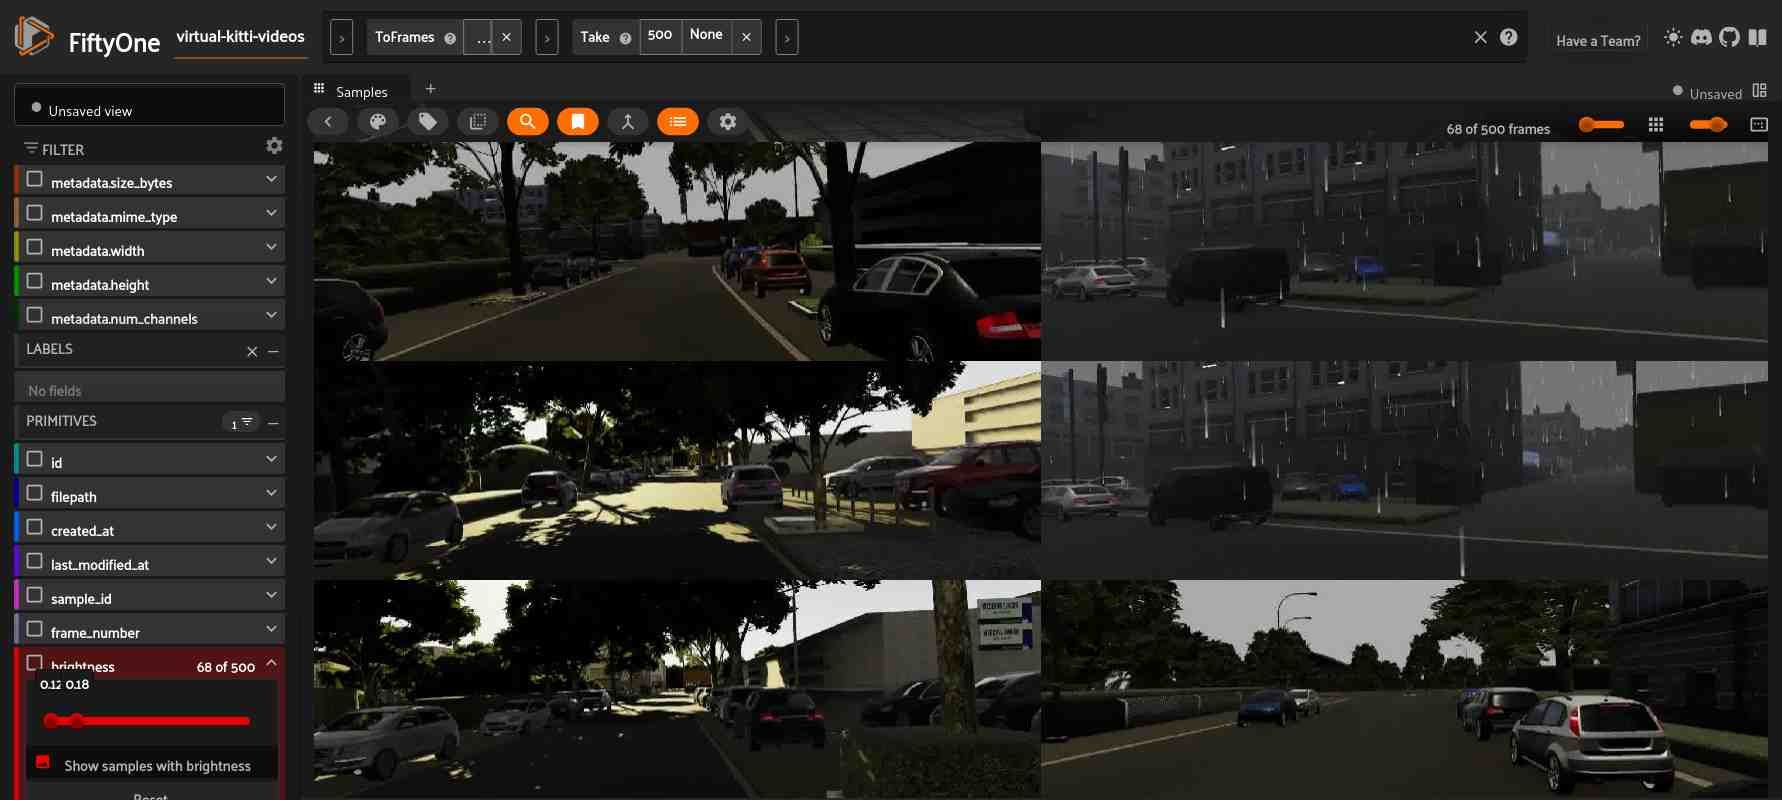

In [9]:
session = fo.launch_app(view_frames)

In [10]:
session.freeze()

## **Compute Saturation**

In **FiftyOne**, computing the saturation of your frames can help you identify scenes with varying levels of color intensity, such as sunny scenes or more muted, low-saturation scenes. This can be particularly useful for understanding how your model performs under different lighting and environmental conditions.

### **Step 1: Access the Saturation Operation**
To compute saturation, follow these steps:

1. In the **Browse** view, go to the operations section (located before the settings icon).
2. Type **saturation** in the search bar. This will open up the option to compute saturation for the entire dataset or just the current view.

### **Step 2: Execute the Operation**
Once you've made your selection, click **Execute**. The saturation levels of your frames will be processed.

### **Step 3: Visualize the Saturation**
After the operation completes, a new **"Saturation"** row will appear in the **Primitives** section in the left sidebar. This allows you to:

- Adjust the **saturation range**.
- Visualize frames with **high saturation** (sunny scenes) or **low saturation** (more muted or overcast scenes).

By manipulating the saturation range, you can focus on different lighting conditions and analyze how your model handles varying color intensities across frames.



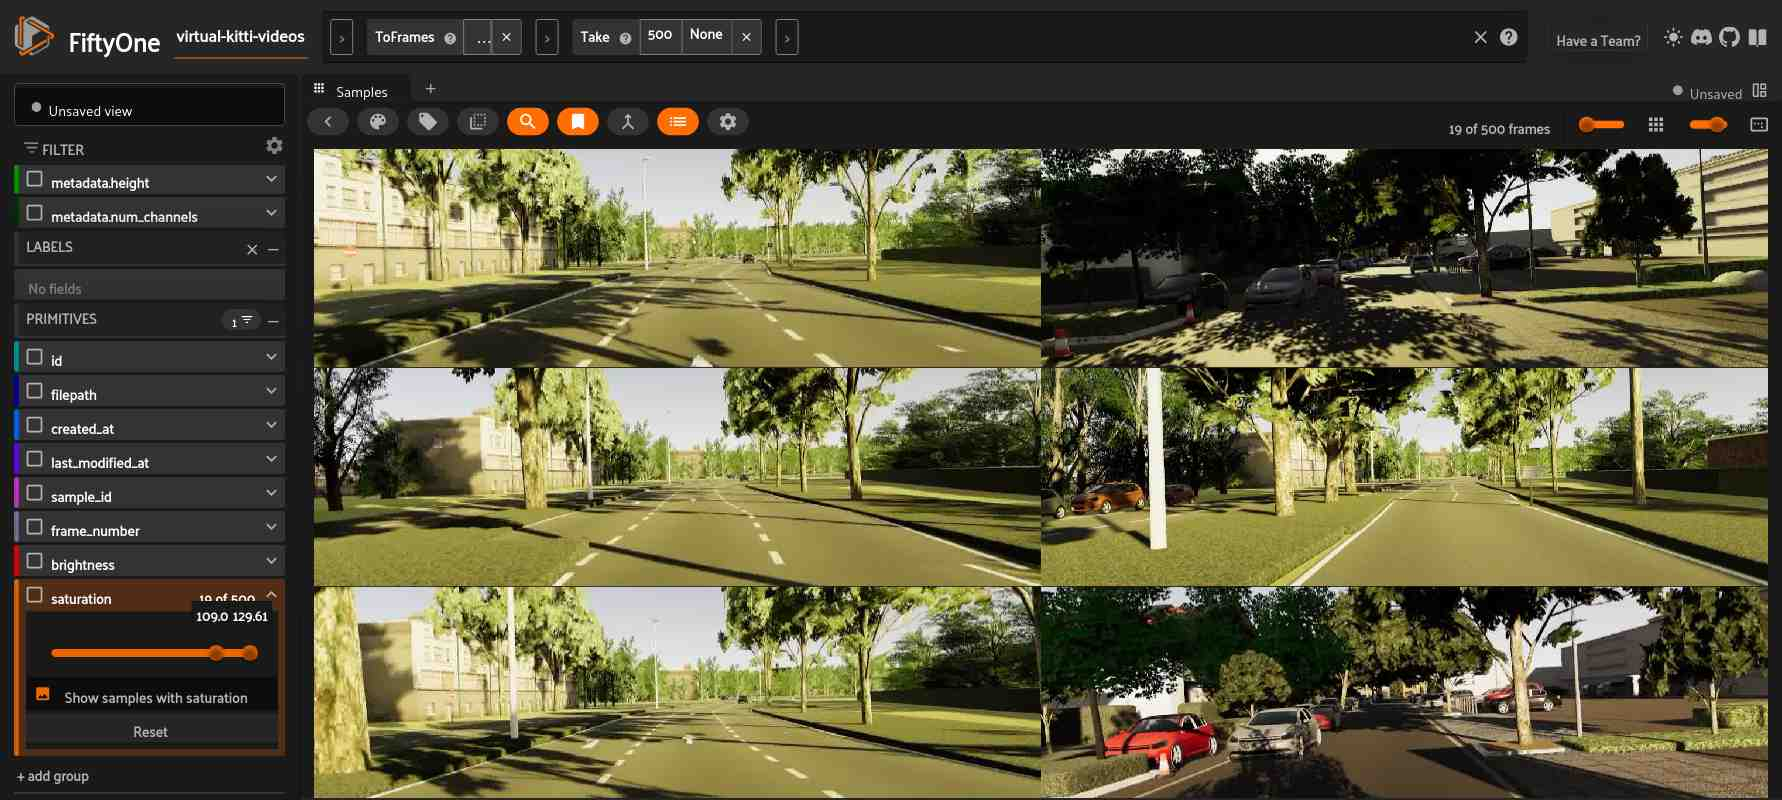

In [13]:
session = fo.launch_app(view_frames)

In [14]:
session.freeze()

## **Object Detection Using Faster R-CNN**

In this section, we will be applying a pre-trained **Faster R-CNN** model for object detection in our video dataset. Faster R-CNN is one of the most powerful and efficient deep learning models for object detection, known for its ability to detect objects quickly and accurately.

### **1. Model Selection**
We will download the Faster R-CNN model from the **FiftyOne model zoo**. This pre-trained model is optimized for a variety of common object detection tasks and can be easily integrated into our workflow for fast evaluation.

### **2. Apply the Model**
Once downloaded, we will apply the Faster R-CNN model to our dataset. By specifying the `label_field`, the model will store its predictions in the relevant field, allowing us to visualize and analyze the results across frames in the dataset. This step makes it easier to see how well the model performs on video frames and to evaluate its accuracy for object detection tasks.


In [16]:
model = fo.zoo.load_zoo_model("faster-rcnn-resnet50-fpn-coco-torch")
kitti_data.apply_model(model, label_field="predictions")

 100% |███████████████| 6800/6800 [10.9m elapsed, 0s remaining, 12.3 samples/s]      



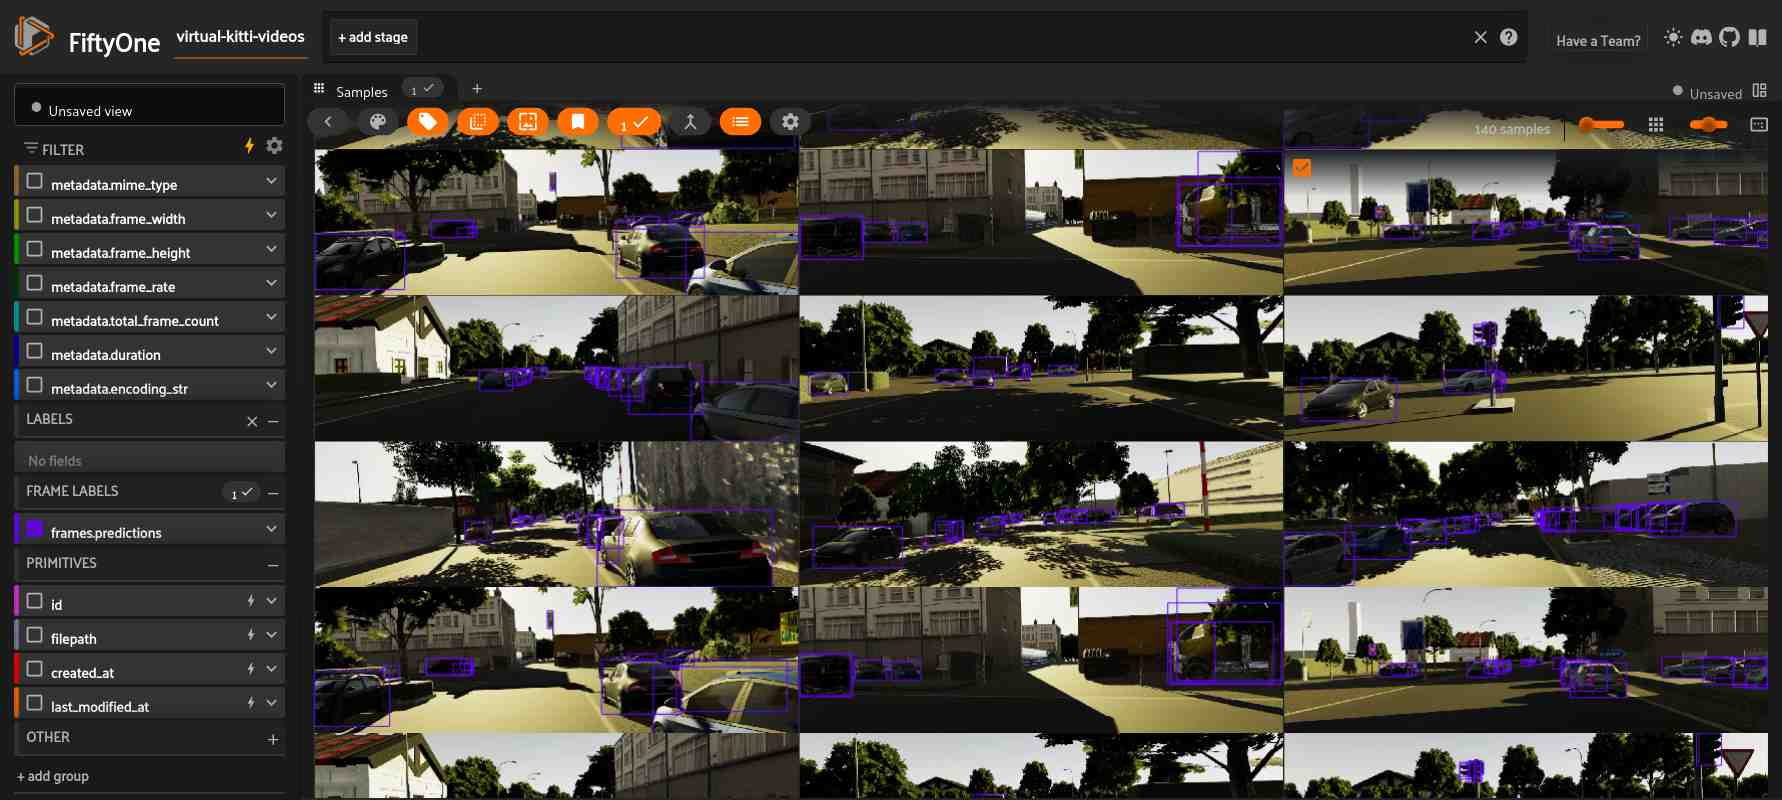

In [12]:
session = fo.launch_app(kitti_data)

In [14]:
session.freeze()

## **Analyze Objects in Frames**

Now that we've seen the model's predictions on the video files, let's take a closer look and analyze the results frame by frame. This allows us to dive deeper into the object detection performance, examining specific frames for precision, false positives, and other critical insights.

### **1. Frame-by-Frame Analysis**
By going through the frames individually, we can inspect how accurately the Faster R-CNN model detected objects. This step is crucial for identifying any patterns in detection errors, such as missed objects or incorrect classifications, especially in challenging frames with dense clutter or low lighting.

### **2. Using FiftyOne for Visualization**
FiftyOne allows us to interactively explore individual frames. You can apply filters to select specific frames—such as those with a high number of detected objects or frames where certain labels appear. This enables more precise analysis and a better understanding of how the model is performing across different scenarios (e.g., fog, low-light conditions, etc.).


In [18]:
frames = kitti_data.to_frames(sample_frames=True)
view_frames = frames.take(500)

 100% |███████████████| 6800/6800 [128.3ms elapsed, 0s remaining, 54.3K samples/s]  


In [19]:
frames

Dataset:     virtual-kitti-videos
Media type:  image
Num samples: 6800
Sample fields:
    id:               fiftyone.core.fields.ObjectIdField
    sample_id:        fiftyone.core.fields.ObjectIdField
    filepath:         fiftyone.core.fields.StringField
    frame_number:     fiftyone.core.fields.FrameNumberField
    tags:             fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:         fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.ImageMetadata)
    created_at:       fiftyone.core.fields.DateTimeField
    last_modified_at: fiftyone.core.fields.DateTimeField
    brightness:       fiftyone.core.fields.FloatField
    saturation:       fiftyone.core.fields.FloatField
    predictions:      fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)
View stages:
    1. ToFrames(config={'sample_frames': True})

In [20]:
print("Total frames in KITTI-videos Dataset: ", kitti_data.count("frames")) 
print("Total detected objects in all frames: ", kitti_data.count("frames.predictions.detections"))  

Total frames in KITTI-videos Dataset:  6800
Total detected objects in all frames:  81690


### The model showcased remarkable robustness, effectively detecting objects in challenging low-light conditions. 


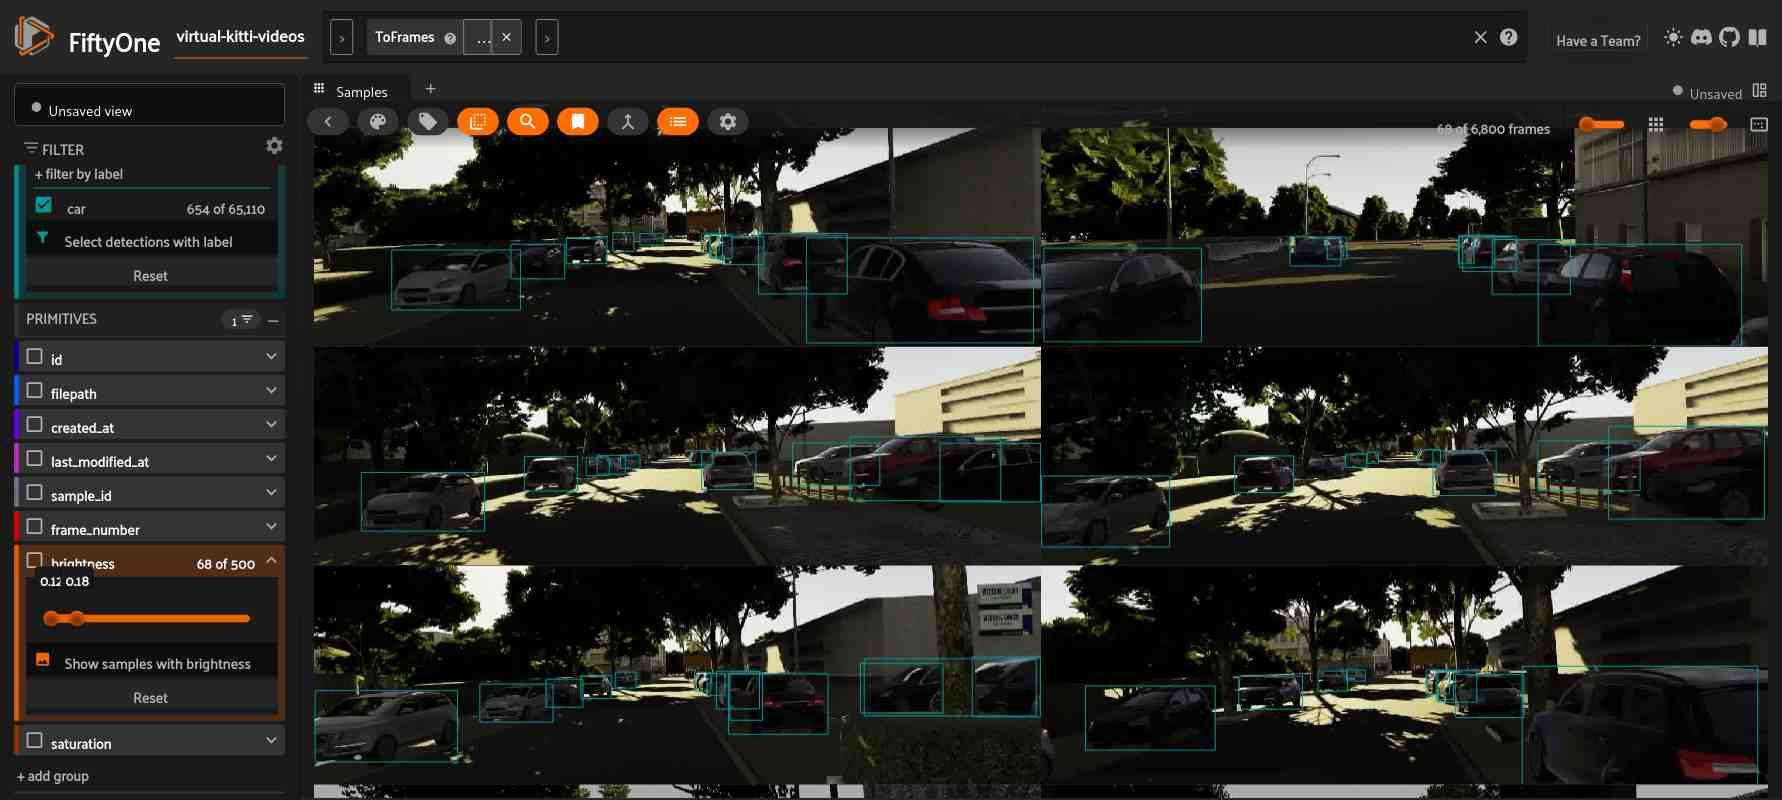

In [21]:
session.view = frames

In [22]:
session.freeze()

### Dense Clutter: Cars obscured by dense tree cover or similar textures to their surroundings were occasionally missed.


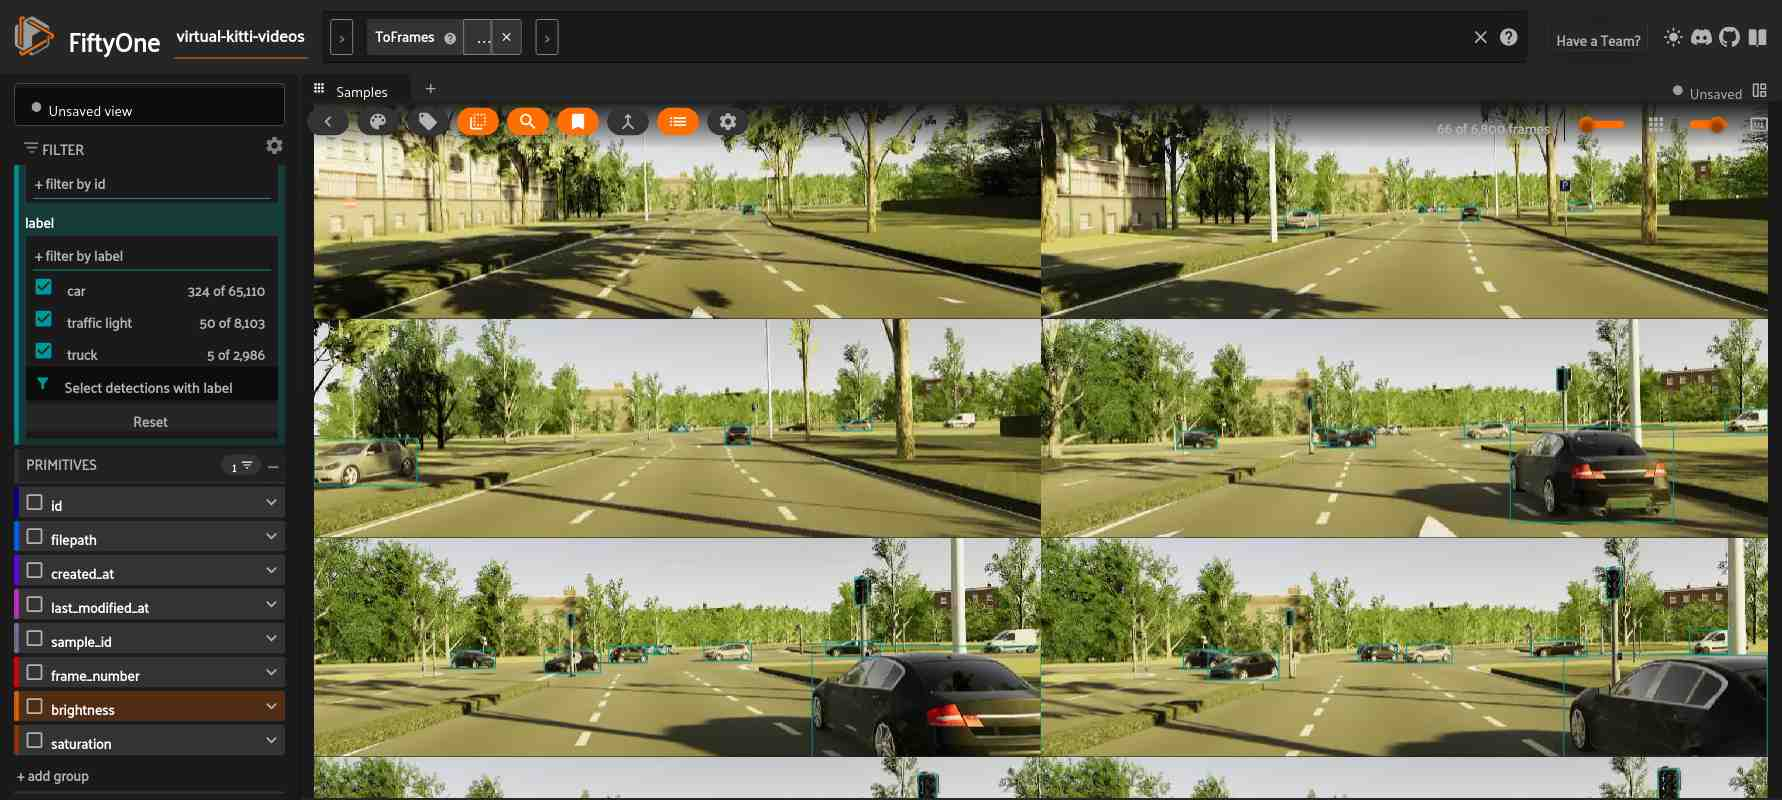

In [23]:
session.view = frames

In [24]:
session.freeze()

### Low-Brightness Scenes: Overcast conditions affected feature extraction, as seen when a truck—typically occupying larger frame regions—went undetected due to poor visibility.


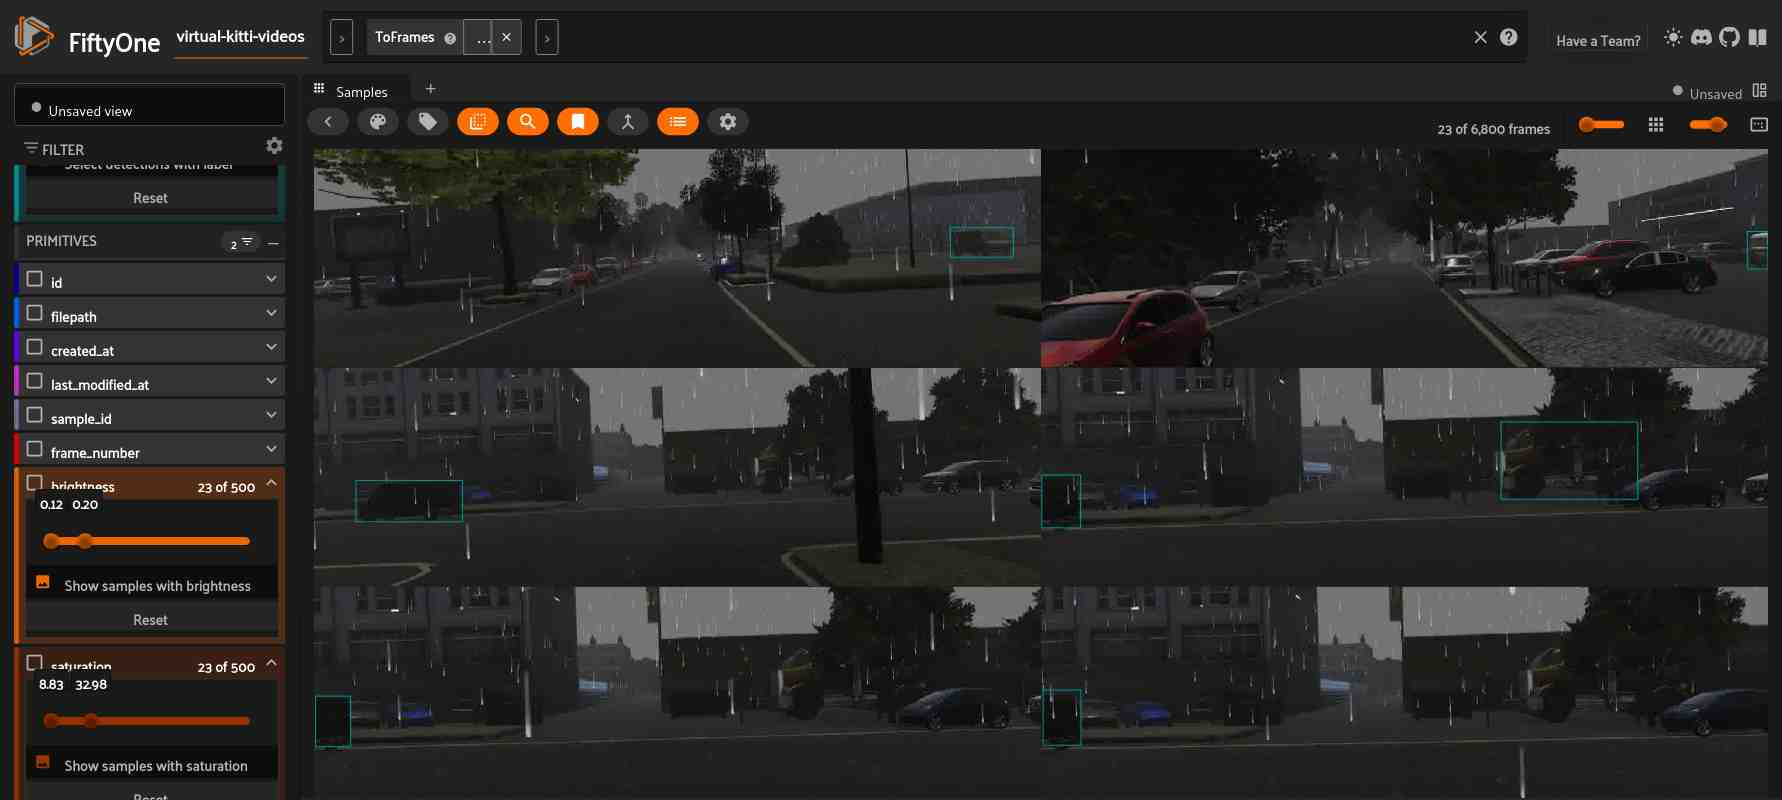

In [25]:
session.view = frames

In [26]:
session.freeze()

### **Visualize the Count of Predicted Objects**

In this step, we'll focus on the predicted objects in 500 frames. Since the Faster R-CNN model is general, we'll select only the relevant objects for our use case, which include:

- **'truck'**
- **'stop sign'**
- **'traffic light'**
- **'car'**
- **'parking meter'**
- **'bird'**
- **'airplane'**
- **'motorcycle'**

Among these objects, the most frequently predicted are **'car'** and **'traffic light'**, with 'car' being the most common, followed by 'traffic light'. This allows us to tailor our analysis to the objects that are most significant for the application at hand.


In [28]:
count_obj = view_frames.count_values("predictions.detections.label")
count_obj

{'airplane': 8,
 'elephant': 1,
 'truck': 224,
 'person': 144,
 'stop sign': 73,
 'potted plant': 4,
 'bench': 22,
 'bed': 1,
 'traffic light': 521,
 'suitcase': 1,
 'backpack': 1,
 'vase': 1,
 'cake': 1,
 'dining table': 1,
 'car': 4692,
 'parking meter': 48,
 'couch': 2,
 'bottle': 1,
 'chair': 5,
 'fire hydrant': 10,
 'umbrella': 2,
 'skateboard': 1,
 'bird': 3,
 'kite': 7,
 'bus': 56,
 'motorcycle': 5,
 'train': 8,
 'boat': 6,
 'bicycle': 3}

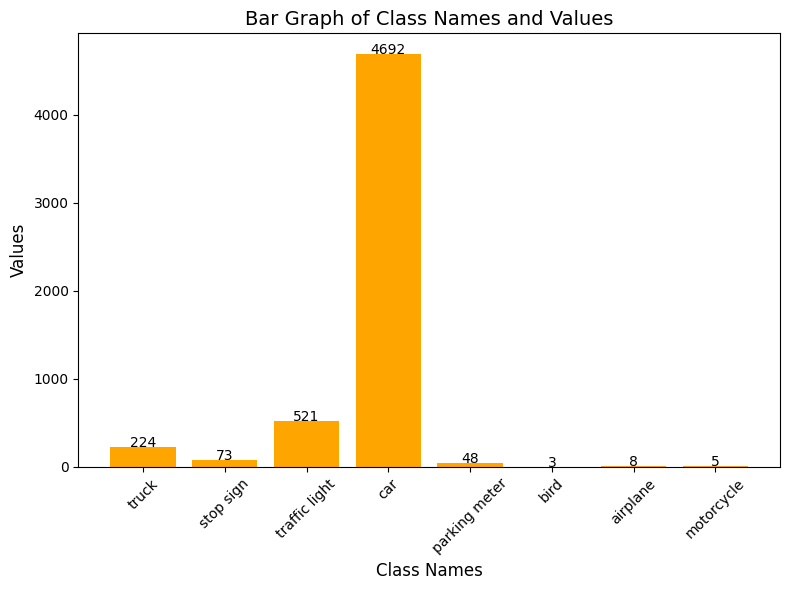

In [31]:
class_names = ['truck', 'stop sign', 'traffic light', 'car', 'parking meter', 'bird', 'airplane', 'motorcycle']
values = [count_obj[key] for key in class_names]

# Create the bar graph
plt.figure(figsize=(8, 6))
plt.bar(class_names, values, color='orange')

# Add labels and title
plt.xlabel('Class Names', fontsize=12)
plt.ylabel('Values', fontsize=12)
plt.title('Bar Graph of Class Names and Values', fontsize=14)
plt.xticks(rotation=45)
# Show value labels on top of each bar
for i, value in enumerate(values):
    plt.text(i, value + 0.5, str(value), ha='center', fontsize=10)

# Display the graph
plt.tight_layout()
plt.show()

### **Using FiftyOne ViewField for Filtering and Analysis**

1. **Filter Labels Based on Confidence and Predicted Objects Count**
   
   Using FiftyOne's `ViewField`, we can filter frames based on the confidence of predictions and only include frames with at least **10 predicted objects**. This filter helps us focus on frames where the model makes multiple predictions, giving us a more in-depth look at the scenes with higher object density. 

   To filter:
   - Set a **confidence threshold** for predictions (e.g., `confidence >= 0.5`).
   - Filter for frames that have **at least 10 predicted objects**. 
   
   This allows us to create a subset of the dataset, which can then be used for more detailed analysis or even for model training on more complex scenes.

In [35]:
view = view_frames.filter_labels(
    "predictions",
    (F("confidence") > 0.9)
).match(
    F("predictions.detections").length() > 10
)
view

Dataset:     virtual-kitti-videos
Media type:  image
Num samples: 32
Sample fields:
    id:               fiftyone.core.fields.ObjectIdField
    sample_id:        fiftyone.core.fields.ObjectIdField
    filepath:         fiftyone.core.fields.StringField
    frame_number:     fiftyone.core.fields.FrameNumberField
    tags:             fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:         fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.ImageMetadata)
    created_at:       fiftyone.core.fields.DateTimeField
    last_modified_at: fiftyone.core.fields.DateTimeField
    predictions:      fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)
View stages:
    1. ToFrames(config={'sample_frames': True})
    2. Take(size=500, seed=None)
    3. FilterLabels(field='predictions', filter={'$gt': ['$$this.confidence', 0.9]}, only_matches=True, trajectories=False)
    4. Match(filter={'$expr': {'$gt': [...]}})


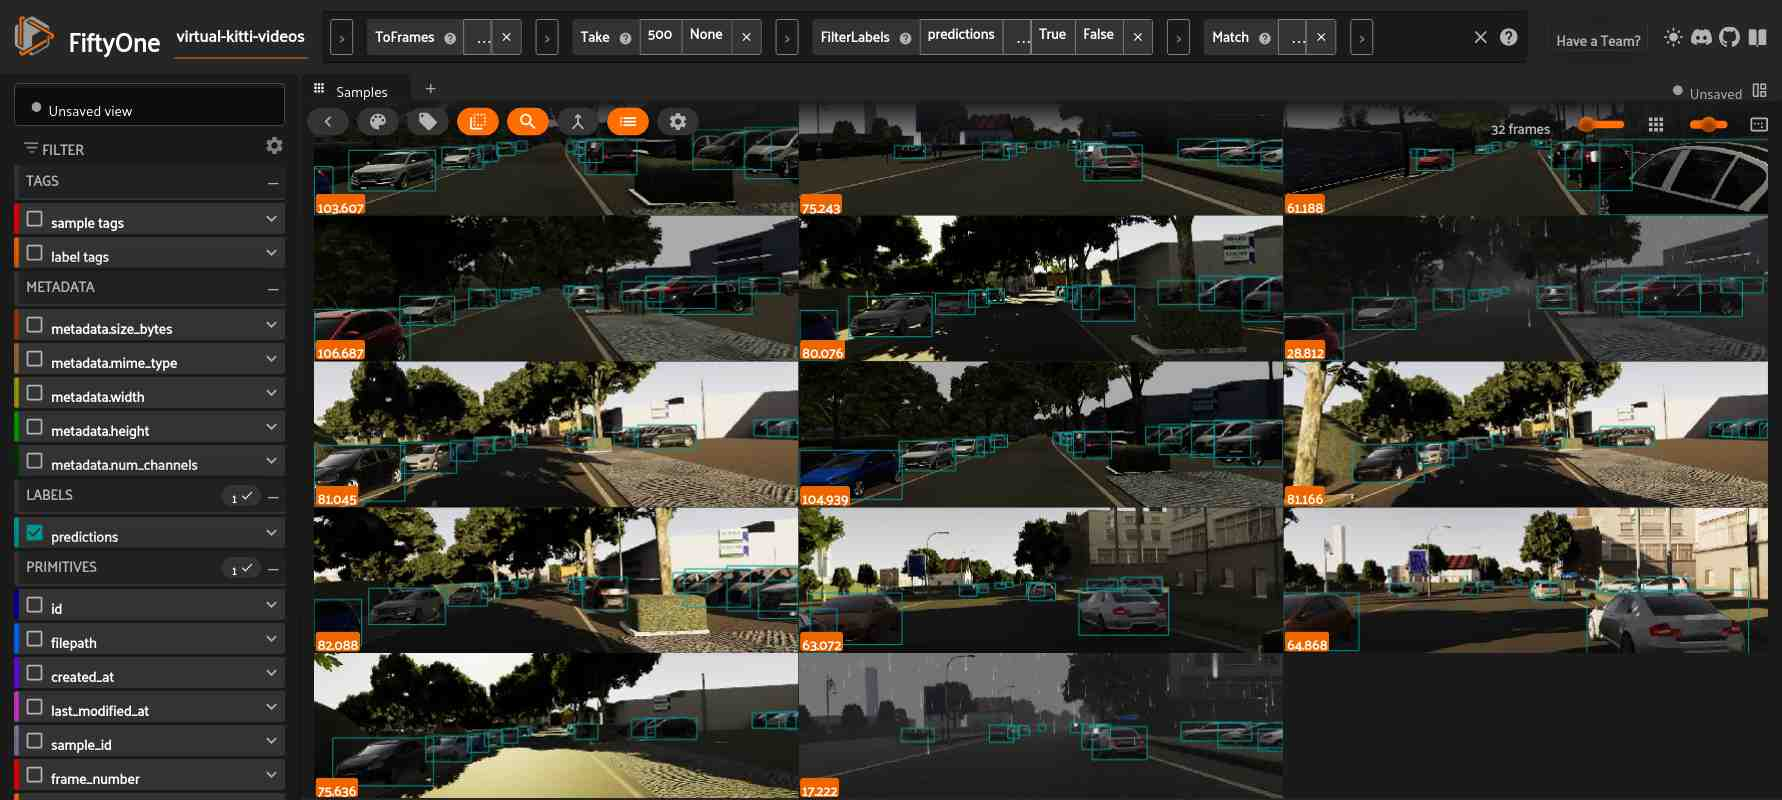

In [36]:
session.view = view

In [37]:
session.freeze()

2. **Get only Truck frames**

    To analyze only frames containing trucks, we can filter the dataset based on the `truck` label. 

    This is useful when we want to focus specifically on a particular class (e.g., truck detection), helping us isolate frames that contain this object. Once the subset is created, we can use it for further analysis or training specific to that class.

In [41]:
truck_frames = view_frames.filter_labels('predictions', 
                     (F('confidence') > 0.9) & 
                     (F('label') == "truck")
                     )
truck_frames

Dataset:     virtual-kitti-videos
Media type:  image
Num samples: 26
Sample fields:
    id:               fiftyone.core.fields.ObjectIdField
    sample_id:        fiftyone.core.fields.ObjectIdField
    filepath:         fiftyone.core.fields.StringField
    frame_number:     fiftyone.core.fields.FrameNumberField
    tags:             fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:         fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.ImageMetadata)
    created_at:       fiftyone.core.fields.DateTimeField
    last_modified_at: fiftyone.core.fields.DateTimeField
    predictions:      fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)
View stages:
    1. ToFrames(config={'sample_frames': True})
    2. Take(size=500, seed=None)
    3. FilterLabels(field='predictions', filter={'$and': [{...}, {...}]}, only_matches=True, trajectories=False)


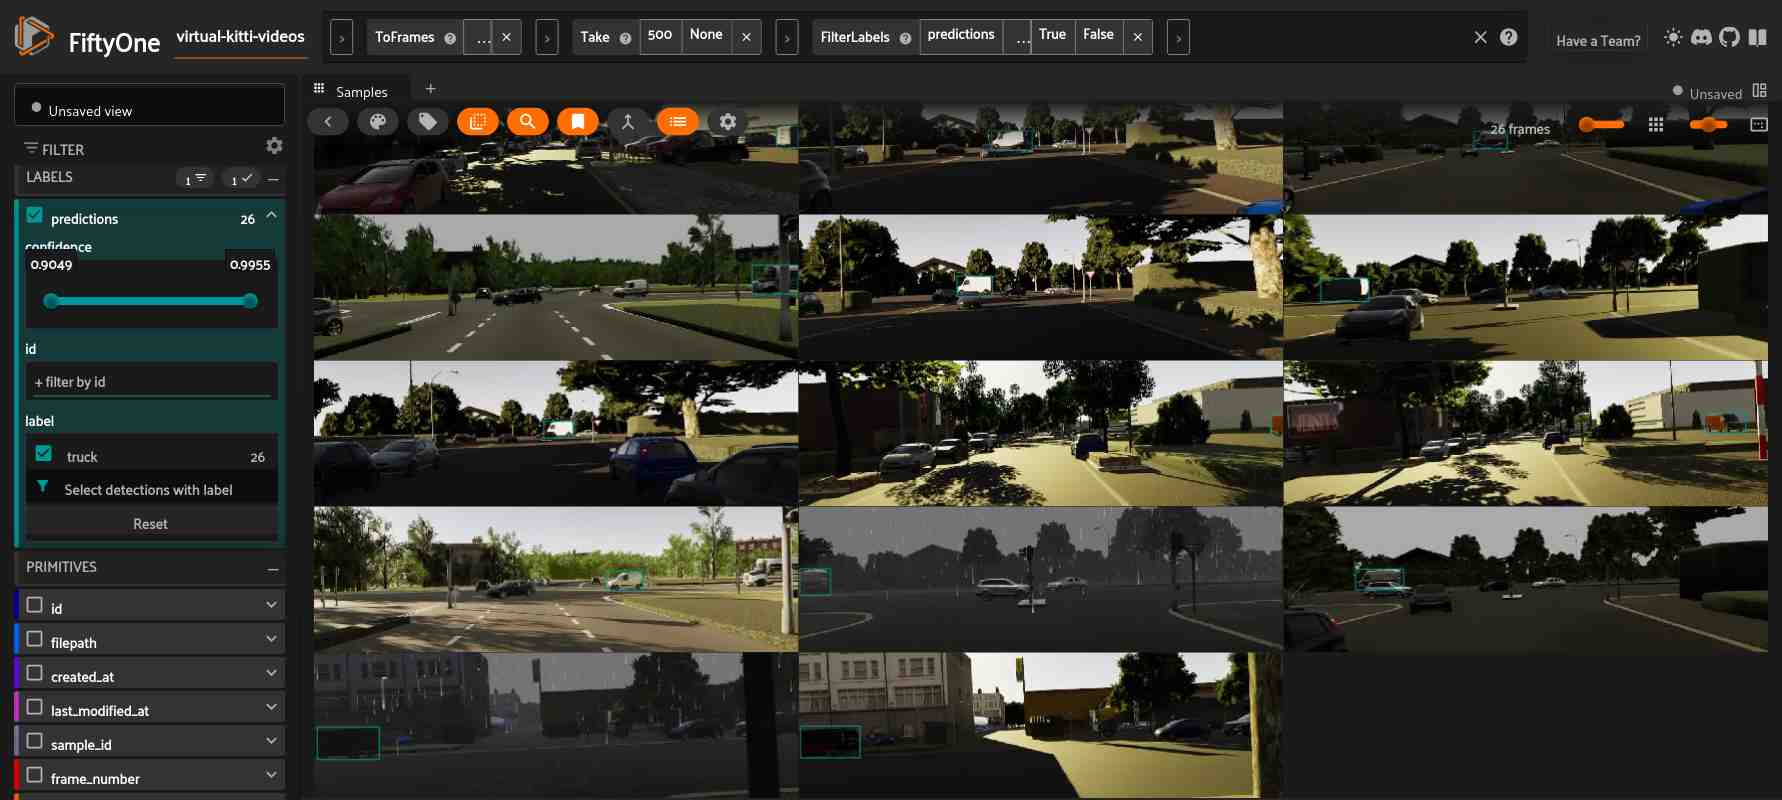

In [42]:
session.view = truck_frames

In [43]:
session.freeze()

## **Conclusion**

This experiment demonstrates how combining synthetic datasets with **FiftyOne** can significantly enhance video object detection workflows. 

These datasets provide a controlled, yet realistic, environment that accelerates model development and refinement before deploying in real-world scenarios.

AI-powered object detection is reshaping video analysis by increasing accuracy, automating processes, and improving efficiency across various industries. 

**FiftyOne** simplifies the development process by offering powerful tools for dataset management, error analysis, and visualization. 


### **Key Takeaways**

- **Integrating Video Data into FiftyOne**: We learned how to load video datasets, explore individual frames, and assess the quality of the dataset.

- **Model Evaluation**: We explored bounding box predictions on videos and frames, addressing challenges such as dense object clutter and low-light conditions.

- **Data Visualization with Filter Views**: We utilized filtering options to isolate frames based on specific object counts or labels, improving our analysis of the dataset.

Stay tuned for more tutorials and experiments using **FiftyOne** and other exciting AI tools in upcoming posts!
